# Face Recognition

In [1]:
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils import data
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

from torch.optim import Optimizer
import torch.nn.functional as F
from torch import Tensor

from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

from torchvision.transforms import v2
import torchvision.transforms as transforms
from torchvision.io import read_image
from PIL import Image

from tqdm import tqdm
import numba as nb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

from os import path
import os
import random
from itertools import chain
from tempfile import TemporaryDirectory
import time
from collections import defaultdict
from typing import Callable, Optional, Tuple, IO, List

print("CUDA Available", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available True


### Connecting to Drive for checkpoints

In [2]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/COS30082/face_reco/face_cut_data.zip -d /content
!cp /content/drive/MyDrive/COS30082/face_reco/verification_pairs_val.txt /content/face_cut_data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/face_cut_data/verification_data/00064085.jpg  
  inflating: /content/face_cut_data/verification_data/00064086.jpg  
  inflating: /content/face_cut_data/verification_data/00064087.jpg  
  inflating: /content/face_cut_data/verification_data/00064088.jpg  
  inflating: /content/face_cut_data/verification_data/00064089.jpg  
  inflating: /content/face_cut_data/verification_data/00064090.jpg  
  inflating: /content/face_cut_data/verification_data/00064091.jpg  
  inflating: /content/face_cut_data/verification_data/00064092.jpg  
  inflating: /content/face_cut_data/verification_data/00064093.jpg  
  inflating: /content/face_cut_data/verification_data/00064094.jpg  
  inflating: /content/face_cut_data/verification_data/00064095.jpg  
  inflating: /content/face_cut_data/verification_data/00064096.jpg  
  inflating: /content/face_cut_data/verification_data/00064097.jpg  
  inflating: /content/face_cut_data/verification_dat

In [4]:
CHECKPOINTS_FOLDER = "/content/drive/MyDrive/COS30082/face_reco"
BASE_FOLDER = "/content/face_cut_data"

## Training Configurations

In [5]:
INPUT_SIZE = (224, 224)
BATCH_SIZE = 512
NUM_WORKERS = 10

data_transforms = {
  "classifier": {
    "train": v2.Compose([
      v2.Resize(size=INPUT_SIZE),
      v2.RandomHorizontalFlip(p=0.5),
      v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1),
      v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=None, shear=10),
      transforms.ToTensor(),
      v2.ToDtype(torch.float32, scale=True),
      v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": v2.Compose([
      v2.Resize(size=INPUT_SIZE),
      transforms.ToTensor(),
      v2.ToDtype(torch.float32, scale=True),
      v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
  },
  "triplet": {
    "train": v2.Compose([
      v2.Resize(size=INPUT_SIZE),
      v2.RandomHorizontalFlip(p=0.5),
      v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1),
      v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=None, shear=10),
      v2.ToDtype(torch.float32, scale=True),
      v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": v2.Compose([
      v2.Resize(size=INPUT_SIZE),
      v2.ToDtype(torch.float32, scale=True),
      v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
  },
  "verify": v2.Compose([
    v2.Resize(size=INPUT_SIZE),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
}

## Datasets

#### Triplet

In [6]:
class TripletDataset(Dataset):
  def __init__(self, root: str, transform: Optional[Callable] = None):
    """
    Initializes the TripletDataset with the given root directory and optional transform.

    Args:
      root (str): Path to the root directory containing class folders.
      transform (callable, optional): Transform to apply to the images.
    """
    self.root = root
    self.image_paths = []
    self.labels = []

    for class_name in sorted(os.listdir(root)):
      class_path = os.path.join(root, class_name)
      if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
          image_path = os.path.join(class_path, image_file)
          self.image_paths.append(image_path)
          self.labels.append(class_name)

    self.labels = np.array(self.labels)
    self.transform = transform

  def __len__(self) -> int:
    """
    Returns the number of images in the dataset.

    Returns:
      int: Number of images in the dataset.
    """
    return len(self.image_paths)

  def __load_image(self, path) -> Tensor:
    """
    Loads and optionally transforms an image.

    Args:
      path (str): Path to the image file.

    Returns:
      Tensor: Transformed image.
    """
    image = read_image(path)
    if self.transform:
      image = self.transform(image)
    return image

  def __positive_candidates(self, label: str, idx: int) -> np.ndarray:
    """
    Gets indices of images with the same label, excluding the current index.

    Args:
      label (str): Label of the current image.
      idx (int): Index of the current image.

    Returns:
      np.ndarray: Indices of positive candidate images.
    """
    return np.where((self.labels == label) & (np.arange(len(self.labels)) != idx))[0]

  def __negative_candidates(self, label: str) -> np.ndarray:
    """
    Gets indices of images with different labels.

    Args:
      label (str): Label of the current image.

    Returns:
      np.ndarray: Indices of negative candidate images.
    """
    return np.where(self.labels != label)[0]

  def __getitem(self, idx: int) -> Tuple[Tensor, Tensor, Tensor]:
    """
    Loads the image at the specified index.

    Args:
      idx (int): Index of the image to load.

    Returns:
      Tensor: Loaded and optionally transformed image.
    """
    image_path = self.image_paths[idx]
    return self.__load_image(image_path)  # Replace with your image loading function

  def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor, Tensor]:
    """
    Gets the anchor, positive, and negative images for the given index.

    Args:
      idx (int): Index of the anchor image.

    Returns:
      tuple: A tuple containing the anchor image (Tensor),
             positive image (Tensor), and negative image (Tensor).
    """
    label = self.labels[idx]
    image = self.__getitem(idx)

    # Triplet selection logic goes here (explained below)
    positive, negative = self.get_triplet(idx, label)

    if positive is None:
      positive = image

    return image, positive, negative

  def get_triplet(self, idx, label) -> Tuple[Optional[Tensor], Tensor]:
    """
    Gets the positive and negative images for the triplet.

    Args:
      idx (int): Index of the anchor image.
      label (str): Label of the anchor image.

    Returns:
      tuple: Positive image and negative image.
    """
    positive_candidates = self.__positive_candidates(label, idx)
    if len(positive_candidates) > 0:
      positive_idx = np.random.choice(positive_candidates)
      positive = self.__getitem(positive_idx)
    else:
      positive = None

    negative_candidates = self.__negative_candidates(label)
    negative_idx = np.random.choice(negative_candidates)
    negative = self.__getitem(negative_idx)

    return positive, negative

### Verification

In [9]:
class VerificationDataset(torch.utils.data.Dataset):
	def __init__(self, image_dir: str, labels_file: str, type: str = "val", transform: Optional[Callable] = None):
		"""
		Initializes the VerificationDataset with the given directory, labels file, type, and optional transform.

		Args:
			image_dir (str): Path to the directory containing images.
			labels_file (str): Path to the file containing image pairs and labels.
			type (str, optional): Type of the dataset, "val" for validation or "test" for testing. Default is "val".
			transform (callable, optional): Transform to apply to the images.
		"""

		self.image_dir = image_dir
		self.labels_file = labels_file
		self.transform = transform
		self.type = type

		# Load pairs and labels from the text file
		self.pairs = []
		self.labels = []
		with open(labels_file, 'r') as f:
			for line in f:
				if type == "val":
					img1, img2, label = line.strip().split(' ')
					img1 = os.path.join(image_dir, img1)
					img2 = os.path.join(image_dir, img2)
					self.pairs.append((img1, img2))
					self.labels.append(int(label) == 1)
				elif type == "test":
					img1, img2 = line.strip().split(' ')
					img1 = os.path.join(image_dir, img1)
					img2 = os.path.join(image_dir, img2)
					self.pairs.append((img1, img2))

	def __len__(self) -> int:
		"""
		Returns the number of image pairs in the dataset.

		Returns:
			int: Number of image pairs in the dataset.
		"""
		return len(self.pairs)

	def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor, Optional[Tensor]]:
		"""
		Gets the images and label (if validation) or image paths (if testing) for the given index.

		Args:
			idx (int): Index of the image pair.

		Returns:
			tuple: A tuple containing:
							- img1 (Tensor): The first image in the pair.
							- img2 (Tensor): The second image in the pair.
							- label (Tensor, optional): The label indicating if the images are of the same class (validation only).
							- img1_path (str, optional): The path of the first image (testing only).
							- img2_path (str, optional): The path of the second image (testing only).
		"""
		try:
			img1_path, img2_path = self.pairs[idx]
			img1 = self.__load_image(img1_path)
			img2 = self.__load_image(img2_path)
		except Exception as e:
			img1 = []
			img2 = []
			label = 0

		if self.type == "val":
			label = torch.tensor(self.labels[idx])
			return img1, img2, label
		elif self.type == "test":
			return img1, img2, img1_path, img2_path

	def __load_image(self, path: str) -> Tensor:
		"""
		Loads and optionally transforms an image.

		Args:
			path (str): Path to the image file.

		Returns:
			Tensor: Loaded and optionally transformed image.
		"""
		image = read_image(path)

		if self.transform:
			image = self.transform(image)

		return image

## Dataloaders

### Classifier

In [10]:
classifier_val_ds = ImageFolder(
  root=path.join(BASE_FOLDER, "classification_data/val_data"),
  transform=data_transforms["classifier"]["val"],
)

classifier_train_ds = ImageFolder(
  root=path.join(BASE_FOLDER, "classification_data/train_data"),
  transform=data_transforms["classifier"]["train"],
)
print(len(classifier_train_ds.classes))

classifier_val_dl = DataLoader(
  classifier_val_ds,
  batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
  pin_memory=True, shuffle=True,
)

classifier_train_dl = DataLoader(
  classifier_train_ds,
  batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
  pin_memory=True, shuffle=True,
)

assert len(classifier_train_ds.classes) == len(classifier_val_ds.classes)

4000


### Triplet

In [11]:
triplet_val_ds = TripletDataset(
  root=path.join(BASE_FOLDER, "classification_data/val_data"),
  transform=data_transforms["triplet"]["val"],
)

triplet_train_ds = TripletDataset(
  root=path.join(BASE_FOLDER, "classification_data/train_data"),
  transform=data_transforms["triplet"]["train"],
)

triplet_val_dl = DataLoader(
  triplet_val_ds,
  batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
  pin_memory=True, shuffle=True,
)

triplet_train_dl = DataLoader(
  triplet_train_ds,
  batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
  pin_memory=True, shuffle=True,
)

### Verification

In [12]:
veri_val_ds = VerificationDataset(
	BASE_FOLDER,
	path.join(BASE_FOLDER, "verification_pairs_val.txt"),
	transform=data_transforms["verify"],
)

veri_val_dl = DataLoader(veri_val_ds, num_workers=NUM_WORKERS, pin_memory=True)

## Model

### Confirming Base Model Layout

In [ ]:
mobilenet = mobilenet_v2(pretrained=True)
mobilenet.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

### Custom Model based of MobileNet

In [13]:
class Net(nn.Module):
  def __init__(self, num_classes: int = 4000, emb_size: int = 256, classify: bool = True):
    """
    Initializes the Net model with a MobileNetV2 base, an embedding layer, and an optional classification layer.

    Args:
      num_classes (int, optional): Number of classes for the classification layer. Default is 4000.
      emb_size (int, optional): Size of the embedding. Default is 256.
      classify (bool, optional): Whether to include the classification layer. Default is True.
    """

    super().__init__()
    self.classify = classify

    self.base = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

    # Freeze the base model (optional)
    for param in self.base.parameters():
      param.requires_grad = False

    num_ftrs = self.base.classifier[1].in_features

    # Creating the layer for generating embedding
    self.base.classifier = nn.Linear(num_ftrs, emb_size)
    for param in self.base.classifier.parameters():
      param.requires_grad = True

    self.bn = nn.BatchNorm1d(emb_size, eps=0.001, momentum=0.1, affine=True)

    # Linear layer for classification
    self.logits = nn.Linear(emb_size, num_classes)

  def forward(self, x: Tensor) -> Tensor:
    """
    Defines the forward pass of the Net model.

    Args:
      x (Tensor): Input tensor.

    Returns:
      Tensor: Output tensor, either embeddings or class logits.
    """

    # Pass through MobileNetV2 base
    x = self.base(x)
    x = self.bn(x)
    if self.classify:
      x = self.logits(x)
    else:
      x = F.normalize(x, p=2, dim=1)
    return x

## Training Functions

### Util Functions

In [15]:
def fit(
  model_name: str, model: nn.Module, train_fn: Callable, optimizer: Optimizer,
  criterion: Callable, train_dl: DataLoader, val_dl: DataLoader,
  device: torch.device, start_epoch: int, num_epochs: int, history_log_file: IO,
) -> None:
  """
  Trains and evaluates the model, saving the best model parameters and logging training history.

  Args:
    model_name (str): The name of the model.
    model (nn.Module): The model to be trained and evaluated.
    train_fn (Callable): The function to train and evaluate the model.
    optimizer (Optimizer): The optimizer for training the model.
    criterion (Callable): The loss function.
    train_dl (DataLoader): DataLoader for the training set.
    val_dl (DataLoader): DataLoader for the validation set.
    device (torch.device): The device to run the model on (e.g., 'cuda' or 'cpu').
    start_epoch (int): The starting epoch number.
    num_epochs (int): The total number of epochs to train.
    history_log_file (IO): A file object to log the training history.
  """
  with TemporaryDirectory() as tempdir:
    since = time.time()

    best_model_params_path = path.join(tempdir, f"_model_{model_name}.pth")
    torch.save(model.state_dict(), best_model_params_path)

    best_acc = 0.0

    while start_epoch < num_epochs:
      print(f"Epoch {start_epoch + 1}/{num_epochs}")

      train_loss, train_acc = train_fn("train", model, optimizer, criterion, train_dl, device)
      val_loss, val_acc = train_fn("val", model, optimizer, criterion, val_dl, device)

      history_log_file.write(f"{val_acc.item()},{val_loss},{train_acc.item()},{train_loss}\n")

      if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_model_params_path)

      torch.save(model.state_dict(), f"{CHECKPOINTS_FOLDER}/{model_name}/model_{start_epoch}.pth")
      torch.save(model.state_dict(), f"{CHECKPOINTS_FOLDER}/{model_name}/optimizer_{start_epoch}.pth")

      start_epoch += 1

    model.load_state_dict(torch.load(best_model_params_path))

    time_elapsed = time.time() - since
    print(f'Complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

In [16]:
def plot_checkpoints(name: str, df: pd.DataFrame) -> None:
  """
  Plots the training and validation accuracy and loss over epochs.

  Args:
    name (str): The title of the plot.
    df (pd.DataFrame): A DataFrame containing the training history with columns 'train_acc', 'val_acc', 'train_loss', and 'val_loss'.
  """

  # Plotting accuracy
  plt.figure(figsize=(10, 5))
  plt.suptitle(name, fontsize=20)

  plt.subplot(1, 2, 1)
  plt.plot(df['train_acc'], label='Train Accuracy')
  plt.plot(df['val_acc'], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Train vs Validation Accuracy')
  plt.legend()

  # Plotting loss
  plt.subplot(1, 2, 2)
  plt.plot(df['train_loss'], label='Train Loss')
  plt.plot(df['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Train vs Validation Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

### Loss Function

In [17]:
class TripletLossCosine(nn.Module):
  """
  Custom Triplet Loss function using Cosine Similarity.

  Args:
      margin: Margin value for the triplet loss (default: 1.0)
  """
  def __init__(self, margin=0.7):
    super().__init__()
    self.margin = margin

  def forward(self, anchor, positive, negative):
    """
    Calculates the triplet loss based on cosine similarity.

    Args:
        anchor: Embedding vector for the anchor image.
        positive: Embedding vector for the positive (similar) image.
        negative: Embedding vector for the negative (dissimilar) image.

    Returns:
        torch.tensor: Triplet loss value.
    """
    pos_sim = torch.nn.functional.cosine_similarity(anchor, positive)
    neg_sim = torch.nn.functional.cosine_similarity(anchor, negative)

    losses = torch.clamp(self.margin - pos_sim + neg_sim, min=0)

    return losses.mean()

### Classifier Training

In [18]:
def train_classifier(
  phase: str, model: nn.Module, optimizer: Optimizer, criterion: nn.CrossEntropyLoss,
  dl: DataLoader, device: torch.device,
) -> Tuple[float, float]:
  """
  Trains or evaluates the classifier model for one epoch.

  Args:
    phase (str): Phase of training, either 'train' or 'val'.
    model (nn.Module): The model to train or evaluate.
    optimizer (Optimizer): The optimizer for training the model.
    criterion (nn.CrossEntropyLoss): The loss function.
    dl (DataLoader): DataLoader for the dataset.
    device (torch.device): The device to run the model on (e.g., 'cuda' or 'cpu').

  Returns:
    tuple: A tuple containing the epoch loss (float) and epoch accuracy (float).
  """
  if phase == 'train':
    model.train()
  else:
    model.eval()

  running_loss = 0.0
  running_corrects = 0

  for i, data in enumerate(tqdm(dl)):
    X, y = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()

    with torch.set_grad_enabled(phase == 'train'):
      y_hat = model(X)
      loss = criterion(y_hat, y)
      y_hat = torch.argmax(y_hat, dim=1)

      if phase == 'train':
        loss.backward()
        optimizer.step()

      running_loss += loss.item() * X.size(0)
      running_corrects += torch.sum(y_hat == y.data)

  ds_size = len(dl.dataset)
  epoch_loss = running_loss / ds_size
  epoch_acc = running_corrects.double() / ds_size

  print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
  return epoch_loss, epoch_acc

### Triplet Training

In [19]:
def train_triplet(
  phase: str, model: nn.Module, optimizer: Optimizer, criterion: TripletLossCosine,
  dl: DataLoader, device: torch.device
) -> Tuple[float, float]:
	if phase == 'train':
		model.train()
	else:
		model.eval()

	running_loss = 0.0
	running_corrects = torch.tensor(0)

	for i, (anchor, pos, neg) in enumerate(tqdm(dl)):
		anchor, pos, neg = anchor.to(device), pos.to(device), neg.to(device)
		optimizer.zero_grad()

		with torch.set_grad_enabled(phase == 'train'):
			anchor_hat = model(anchor)
			pos_hat = model(pos)
			neg_hat = model(neg)
			loss = criterion(anchor_hat, pos_hat, neg_hat)

			if phase == 'train':
				loss.backward()
				optimizer.step()

			running_loss += loss.item() * anchor.size(0)

			pos_sim = F.cosine_similarity(anchor_hat, pos_hat)
			neg_sim = F.cosine_similarity(anchor_hat, neg_hat)
			running_corrects += ((pos_sim - neg_sim) > criterion.margin).sum().item()

	ds_size = len(dl.dataset)
	epoch_loss = running_loss / ds_size
	epoch_acc = running_corrects.double() / ds_size

	print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
	return epoch_loss, epoch_acc

## Init Models

### Classifier FE

In [20]:
net_classifier_fe = Net(classify=True)
net_classifier_fe = net_classifier_fe.to(device)
criterion_classifier_fe = nn.CrossEntropyLoss()
optimizer_classifier_fe = optim.Adam(
  chain.from_iterable([
    net_classifier_fe.base.classifier.parameters(),
    net_classifier_fe.bn.parameters(),
    net_classifier_fe.logits.parameters(),
  ]),
  lr=1e-3,
)
epoch_classifier_fe = np.array(0)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 57.5MB/s]


### Classifier FT

In [21]:
net_classifier_ft = Net(classify=True)
net_classifier_ft = net_classifier_ft.to(device)
criterion_classifier_ft = nn.CrossEntropyLoss()
optimizer_classifier_ft = optim.Adam(
  net_classifier_ft.parameters(),
  lr=1e-3,
)
epoch_classifier_ft = np.array(0)

### Triplet FE

In [22]:
net_triplet_fe = Net(classify=False)
net_triplet_fe = net_triplet_fe.to(device)
criterion_triplet_fe = TripletLossCosine()
optimizer_triplet_fe = optim.Adam(
  chain.from_iterable([
    net_triplet_fe.base.classifier.parameters(),
    net_triplet_fe.bn.parameters(),
  ]),
  lr=1e-3,
)
epoch_triplet_fe = np.array(0)

### Triplet FT

In [23]:
net_triplet_ft = Net(classify=False)
net_triplet_ft = net_triplet_ft.to(device)
criterion_triplet_ft = TripletLossCosine()
optimizer_triplet_ft = optim.Adam(
  net_triplet_ft.parameters(),
  lr=1e-3,
)
epoch_triplet_ft = np.array(0)

## Training

### Classifier FE

In [ ]:
with open(f"{CHECKPOINTS_FOLDER}/classifier_fe/history.csv", "w+") as f:
  f.write("val_acc,val_loss,train_acc,train_loss\n")
  f.close()

In [ ]:
with open(f"{CHECKPOINTS_FOLDER}/classifier_fe/history.csv", "a+") as history_log_file:
	fit(
		f"classifier_fe", net_classifier_fe, train_classifier,
		optimizer_classifier_fe, criterion_classifier_fe,
		classifier_train_dl, classifier_val_dl, device,
		epoch_classifier_fe, epoch_classifier_fe + 30,
		history_log_file,
	)
	history_log_file.close()

Epoch 1/30


  0%|          | 0/742 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 742/742 [10:52<00:00,  1.14it/s]


train Loss: 7.5680 Acc: 0.0102


100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


val Loss: 7.7309 Acc: 0.0072
Epoch 2/30


100%|██████████| 742/742 [10:52<00:00,  1.14it/s]


train Loss: 7.0395 Acc: 0.0234


100%|██████████| 16/16 [00:11<00:00,  1.42it/s]


val Loss: 7.5936 Acc: 0.0095
Epoch 3/30


100%|██████████| 742/742 [10:45<00:00,  1.15it/s]


train Loss: 6.8785 Acc: 0.0304


100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


val Loss: 7.6205 Acc: 0.0114
Epoch 4/30


100%|██████████| 742/742 [10:51<00:00,  1.14it/s]


train Loss: 6.7885 Acc: 0.0348


100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


val Loss: 7.5595 Acc: 0.0123
Epoch 5/30


100%|██████████| 742/742 [10:53<00:00,  1.14it/s]


train Loss: 6.7280 Acc: 0.0388


100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


val Loss: 7.4575 Acc: 0.0157
Epoch 6/30


100%|██████████| 742/742 [10:49<00:00,  1.14it/s]


train Loss: 6.6844 Acc: 0.0403


100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


val Loss: 7.4626 Acc: 0.0174
Epoch 7/30


100%|██████████| 742/742 [10:56<00:00,  1.13it/s]


train Loss: 6.6505 Acc: 0.0429


100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


val Loss: 7.5362 Acc: 0.0179
Epoch 8/30


100%|██████████| 742/742 [10:39<00:00,  1.16it/s]


train Loss: 6.6222 Acc: 0.0443


100%|██████████| 16/16 [00:11<00:00,  1.44it/s]


val Loss: 7.5696 Acc: 0.0181
Epoch 9/30


100%|██████████| 742/742 [10:53<00:00,  1.13it/s]


train Loss: 6.5934 Acc: 0.0464


100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


val Loss: 7.5587 Acc: 0.0186
Epoch 10/30


100%|██████████| 742/742 [11:01<00:00,  1.12it/s]


train Loss: 6.5797 Acc: 0.0470


100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


val Loss: 7.6632 Acc: 0.0167
Epoch 11/30


100%|██████████| 742/742 [11:05<00:00,  1.11it/s]


train Loss: 6.5584 Acc: 0.0481


100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


val Loss: 7.5920 Acc: 0.0174
Epoch 12/30


100%|██████████| 742/742 [11:04<00:00,  1.12it/s]


train Loss: 6.5439 Acc: 0.0494


100%|██████████| 16/16 [00:10<00:00,  1.48it/s]


val Loss: 7.5395 Acc: 0.0188
Epoch 13/30


100%|██████████| 742/742 [11:03<00:00,  1.12it/s]


train Loss: 6.5289 Acc: 0.0505


100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


val Loss: 7.6053 Acc: 0.0168
Epoch 14/30


100%|██████████| 742/742 [11:12<00:00,  1.10it/s]


train Loss: 6.5167 Acc: 0.0512


100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


val Loss: 7.5853 Acc: 0.0200
Epoch 15/30


100%|██████████| 742/742 [11:02<00:00,  1.12it/s]


train Loss: 6.5051 Acc: 0.0517


100%|██████████| 16/16 [00:11<00:00,  1.44it/s]


val Loss: 7.5492 Acc: 0.0197
Epoch 16/30


100%|██████████| 742/742 [11:04<00:00,  1.12it/s]


train Loss: 6.4937 Acc: 0.0523


100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


val Loss: 7.6238 Acc: 0.0191
Epoch 17/30


100%|██████████| 742/742 [11:01<00:00,  1.12it/s]


train Loss: 6.4801 Acc: 0.0535


100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


val Loss: 7.6546 Acc: 0.0183
Epoch 18/30


100%|██████████| 742/742 [10:57<00:00,  1.13it/s]


train Loss: 6.4738 Acc: 0.0537


100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


val Loss: 7.5609 Acc: 0.0188
Epoch 19/30


100%|██████████| 742/742 [11:00<00:00,  1.12it/s]


train Loss: 6.4641 Acc: 0.0543


100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


val Loss: 7.5967 Acc: 0.0202
Epoch 20/30


100%|██████████| 742/742 [11:00<00:00,  1.12it/s]


train Loss: 6.4560 Acc: 0.0547


100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


val Loss: 7.5846 Acc: 0.0192
Epoch 21/30


100%|██████████| 742/742 [10:55<00:00,  1.13it/s]


train Loss: 6.4527 Acc: 0.0554


100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


val Loss: 7.5867 Acc: 0.0173
Epoch 22/30


100%|██████████| 742/742 [10:58<00:00,  1.13it/s]


train Loss: 6.4435 Acc: 0.0556


100%|██████████| 16/16 [00:10<00:00,  1.48it/s]


val Loss: 7.5803 Acc: 0.0191
Epoch 23/30


100%|██████████| 742/742 [10:58<00:00,  1.13it/s]


train Loss: 6.4393 Acc: 0.0563


100%|██████████| 16/16 [00:11<00:00,  1.45it/s]


val Loss: 7.6776 Acc: 0.0161
Epoch 24/30


100%|██████████| 742/742 [10:54<00:00,  1.13it/s]


train Loss: 6.4329 Acc: 0.0563


100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


val Loss: 7.6265 Acc: 0.0198
Epoch 25/30


100%|██████████| 742/742 [10:56<00:00,  1.13it/s]


train Loss: 6.4252 Acc: 0.0567


100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


val Loss: 7.6070 Acc: 0.0176
Epoch 26/30


100%|██████████| 742/742 [10:55<00:00,  1.13it/s]


train Loss: 6.4182 Acc: 0.0576


100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


val Loss: 7.5943 Acc: 0.0186
Epoch 27/30


100%|██████████| 742/742 [10:55<00:00,  1.13it/s]


train Loss: 6.4158 Acc: 0.0576


100%|██████████| 16/16 [00:11<00:00,  1.42it/s]


val Loss: 7.6698 Acc: 0.0186
Epoch 28/30


100%|██████████| 742/742 [10:54<00:00,  1.13it/s]


train Loss: 6.4063 Acc: 0.0588


100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


val Loss: 7.6638 Acc: 0.0181
Epoch 29/30


100%|██████████| 742/742 [10:53<00:00,  1.14it/s]


train Loss: 6.4048 Acc: 0.0585


100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


val Loss: 7.6048 Acc: 0.0191
Epoch 30/30


100%|██████████| 742/742 [10:56<00:00,  1.13it/s]


train Loss: 6.3996 Acc: 0.0595


100%|██████████| 16/16 [00:11<00:00,  1.44it/s]


val Loss: 7.6868 Acc: 0.0181
Complete in 334m 5s
Best val Acc: 0.020203


In [ ]:
torch.save(net_classifier_fe.state_dict(), f"{CHECKPOINTS_FOLDER}/classifier_fe.pth")

In [ ]:
classifier_fe_history = pd.read_csv(f"{CHECKPOINTS_FOLDER}/classifier_fe/history.csv")

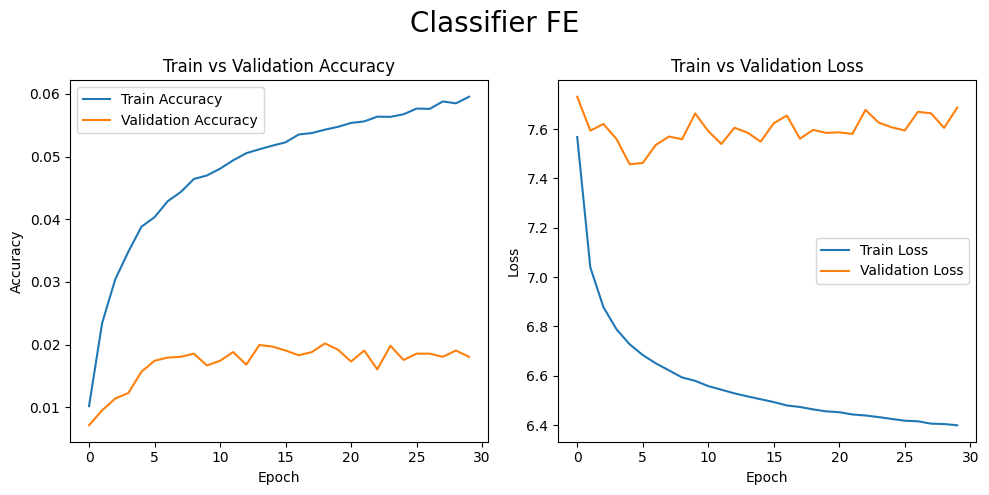

In [ ]:
plot_checkpoints("Classifier FE", classifier_fe_history)

### Classifier FT

In [ ]:
net_classifier_ft.load_state_dict(torch.load(f"{CHECKPOINTS_FOLDER}/classifier_fe.pth"))
# Fine tuning by re-enable grads the few last layers of base model
for param in net_classifier_ft.base.features[-3:].parameters():
  param.requires_grad = True

In [ ]:
with open(f"{CHECKPOINTS_FOLDER}/classifier_ft/history.csv", "w+") as f:
  f.write("val_acc,val_loss,train_acc,train_loss\n")
  f.close()

In [ ]:
with open(f"{CHECKPOINTS_FOLDER}/classifier_ft/history.csv", "a+") as history_log_file:
	fit(
		f"classifier_ft", net_classifier_ft, train_classifier,
		optimizer_classifier_ft, criterion_classifier_ft,
		classifier_train_dl, classifier_val_dl, device,
		epoch_classifier_ft, epoch_classifier_ft + 10,
		history_log_file,
	)
	history_log_file.close()

Epoch 1/10


100%|██████████| 742/742 [11:17<00:00,  1.10it/s]


train Loss: 4.8921 Acc: 0.1719


100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


val Loss: 4.9747 Acc: 0.1710
Epoch 2/10


100%|██████████| 742/742 [11:14<00:00,  1.10it/s]


train Loss: 3.8902 Acc: 0.2875


100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


val Loss: 4.3134 Acc: 0.2378
Epoch 3/10


100%|██████████| 742/742 [11:12<00:00,  1.10it/s]


train Loss: 3.4153 Acc: 0.3534


100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


val Loss: 4.0191 Acc: 0.2812
Epoch 4/10


100%|██████████| 742/742 [11:14<00:00,  1.10it/s]


train Loss: 3.1081 Acc: 0.3972


100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


val Loss: 3.9483 Acc: 0.2963
Epoch 5/10


100%|██████████| 742/742 [11:13<00:00,  1.10it/s]


train Loss: 2.8865 Acc: 0.4318


100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


val Loss: 3.6461 Acc: 0.3406
Epoch 6/10


100%|██████████| 742/742 [11:11<00:00,  1.10it/s]


train Loss: 2.7148 Acc: 0.4591


100%|██████████| 16/16 [00:11<00:00,  1.45it/s]


val Loss: 3.4956 Acc: 0.3608
Epoch 7/10


100%|██████████| 742/742 [11:14<00:00,  1.10it/s]


train Loss: 2.5736 Acc: 0.4807


100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


val Loss: 3.4145 Acc: 0.3786
Epoch 8/10


100%|██████████| 742/742 [11:12<00:00,  1.10it/s]


train Loss: 2.4598 Acc: 0.4992


100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


val Loss: 3.4393 Acc: 0.3768
Epoch 9/10


100%|██████████| 742/742 [11:15<00:00,  1.10it/s]


train Loss: 2.3623 Acc: 0.5142


100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


val Loss: 3.2952 Acc: 0.3970
Epoch 10/10


100%|██████████| 742/742 [11:17<00:00,  1.10it/s]


train Loss: 2.2714 Acc: 0.5295


100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


val Loss: 3.2143 Acc: 0.4022
Complete in 114m 17s
Best val Acc: 0.402183


In [ ]:
torch.save(net_classifier_ft.state_dict(), f"{CHECKPOINTS_FOLDER}/classifier_ft.pth")

In [ ]:
classifier_ft_history = pd.read_csv(f"{CHECKPOINTS_FOLDER}/classifier_ft/history.csv")

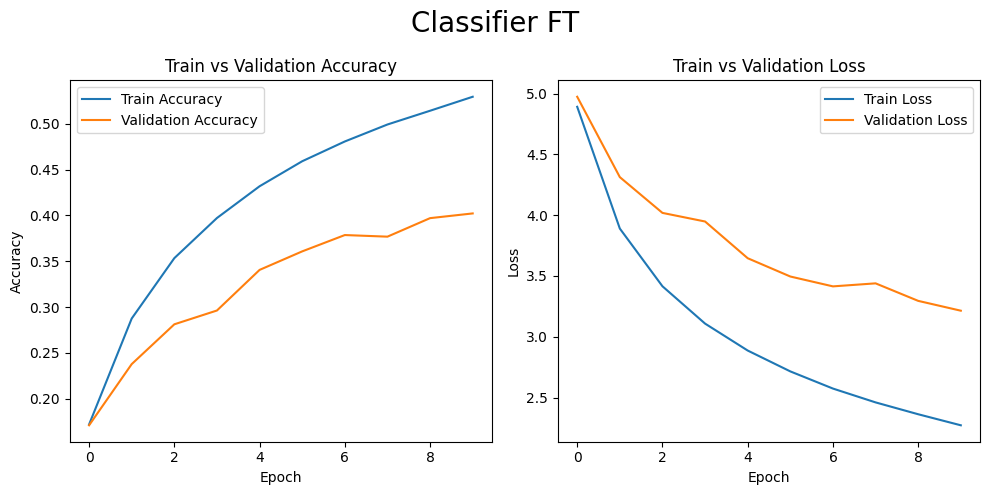

In [ ]:
plot_checkpoints("Classifier FT", classifier_ft_history)

### Triplet FE

In [ ]:
with open(f"{CHECKPOINTS_FOLDER}/triplet_fe/history.csv", "w+") as f:
  f.write("val_acc,val_loss,train_acc,train_loss\n")
  f.close()

In [ ]:
with open(f"{CHECKPOINTS_FOLDER}/triplet_fe/history.csv", "a+") as history_log_file:
	fit(
		f"triplet_fe", net_triplet_fe, train_triplet,
		optimizer_triplet_fe, criterion_triplet_fe,
		triplet_train_dl, triplet_val_dl, device,
		epoch_triplet_fe, epoch_triplet_fe + 10,
		history_log_file,
	)
	history_log_file.close()

Epoch 1/10


100%|██████████| 742/742 [40:22<00:00,  3.27s/it]


train Loss: 0.5338 Acc: 0.1833


100%|██████████| 16/16 [00:29<00:00,  1.82s/it]


val Loss: 0.5192 Acc: 0.1902
Epoch 2/10


100%|██████████| 742/742 [40:33<00:00,  3.28s/it]


train Loss: 0.5136 Acc: 0.2080


100%|██████████| 16/16 [00:26<00:00,  1.67s/it]


val Loss: 0.5183 Acc: 0.1993
Epoch 3/10


100%|██████████| 742/742 [40:31<00:00,  3.28s/it]


train Loss: 0.5108 Acc: 0.2129


100%|██████████| 16/16 [00:28<00:00,  1.77s/it]


val Loss: 0.5153 Acc: 0.2027
Epoch 4/10


100%|██████████| 742/742 [40:32<00:00,  3.28s/it]


train Loss: 0.5052 Acc: 0.2171


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


val Loss: 0.5134 Acc: 0.1950
Epoch 5/10


100%|██████████| 742/742 [40:27<00:00,  3.27s/it]


train Loss: 0.5053 Acc: 0.2175


100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


val Loss: 0.5132 Acc: 0.2038
Epoch 6/10


100%|██████████| 742/742 [40:37<00:00,  3.28s/it]


train Loss: 0.5027 Acc: 0.2195


100%|██████████| 16/16 [00:28<00:00,  1.77s/it]


val Loss: 0.5049 Acc: 0.2231
Epoch 7/10


100%|██████████| 742/742 [40:38<00:00,  3.29s/it]


train Loss: 0.5022 Acc: 0.2191


100%|██████████| 16/16 [00:26<00:00,  1.67s/it]


val Loss: 0.5218 Acc: 0.2020
Epoch 8/10


100%|██████████| 742/742 [40:37<00:00,  3.29s/it]


train Loss: 0.4997 Acc: 0.2221


100%|██████████| 16/16 [00:26<00:00,  1.67s/it]


val Loss: 0.5144 Acc: 0.2112
Epoch 9/10


100%|██████████| 742/742 [40:40<00:00,  3.29s/it]


train Loss: 0.5018 Acc: 0.2210


100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


val Loss: 0.5085 Acc: 0.2249
Epoch 10/10


100%|██████████| 742/742 [40:39<00:00,  3.29s/it]


train Loss: 0.5008 Acc: 0.2203


100%|██████████| 16/16 [00:30<00:00,  1.91s/it]


val Loss: 0.5077 Acc: 0.2221
Complete in 410m 35s
Best val Acc: 0.224871


In [ ]:
torch.save(net_triplet_fe.state_dict(), f"{CHECKPOINTS_FOLDER}/triplet_fe.pth")

In [12]:
triplet_fe_history = pd.read_csv(f"{CHECKPOINTS_FOLDER}/triplet_fe/history.csv")

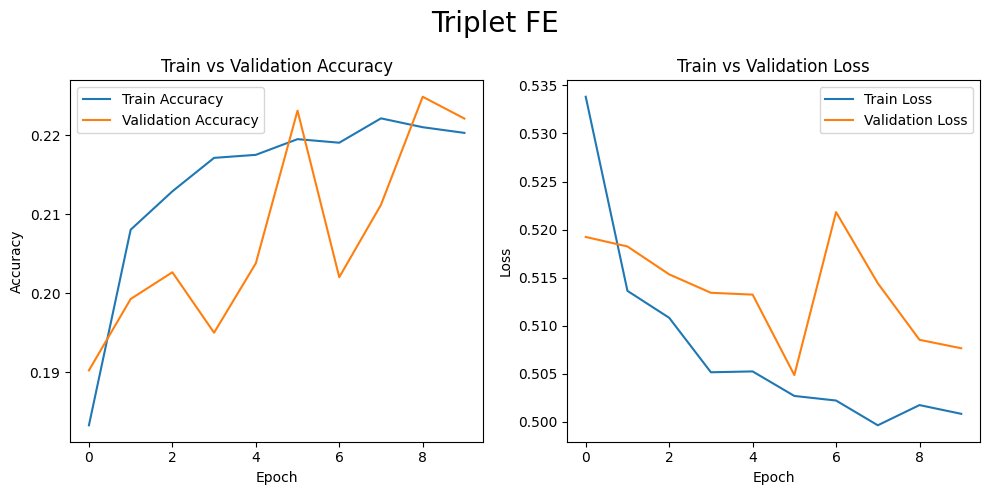

In [13]:
plot_checkpoints("Triplet FE", triplet_fe_history)

### Triplet FT

In [ ]:
net_triplet_ft.load_state_dict(torch.load(f"{CHECKPOINTS_FOLDER}/triplet_fe.pth"))
# Fine tuning by re-enable grads the few last layers of base model
for param in net_triplet_ft.base.features[-3:].parameters():
  param.requires_grad = True

In [ ]:
with open(f"{CHECKPOINTS_FOLDER}/triplet_ft/history.csv", "w+") as f:
  f.write("val_acc,val_loss,train_acc,train_loss\n")
  f.close()

In [ ]:
with open(f"{CHECKPOINTS_FOLDER}/triplet_ft/history.csv", "a+") as history_log_file:
	fit(
		f"triplet_ft", net_triplet_ft, train_triplet,
		optimizer_triplet_ft, criterion_triplet_ft,
		triplet_train_dl, triplet_val_dl, device,
		epoch_triplet_ft, epoch_triplet_ft + 10,
		history_log_file,
	)
	history_log_file.close()

Epoch 1/10


100%|██████████| 742/742 [40:40<00:00,  3.29s/it]


train Loss: 0.3667 Acc: 0.3781


100%|██████████| 16/16 [00:28<00:00,  1.77s/it]


val Loss: 0.3063 Acc: 0.4378
Epoch 2/10


100%|██████████| 742/742 [40:56<00:00,  3.31s/it]


train Loss: 0.3065 Acc: 0.4288


100%|██████████| 16/16 [00:27<00:00,  1.72s/it]


val Loss: 0.2912 Acc: 0.4454
Epoch 3/10


100%|██████████| 742/742 [40:52<00:00,  3.30s/it]


train Loss: 0.2913 Acc: 0.4412


100%|██████████| 16/16 [00:30<00:00,  1.88s/it]


val Loss: 0.2827 Acc: 0.4421
Epoch 4/10


100%|██████████| 742/742 [40:55<00:00,  3.31s/it]


train Loss: 0.2830 Acc: 0.4509


100%|██████████| 16/16 [00:30<00:00,  1.89s/it]


val Loss: 0.2665 Acc: 0.4677
Epoch 5/10


100%|██████████| 742/742 [41:16<00:00,  3.34s/it]


train Loss: 0.2757 Acc: 0.4579


100%|██████████| 16/16 [00:31<00:00,  1.98s/it]


val Loss: 0.2676 Acc: 0.4678
Epoch 6/10


100%|██████████| 742/742 [41:43<00:00,  3.37s/it]


train Loss: 0.2703 Acc: 0.4641


100%|██████████| 16/16 [00:28<00:00,  1.75s/it]


val Loss: 0.2606 Acc: 0.4830
Epoch 7/10


100%|██████████| 742/742 [41:50<00:00,  3.38s/it]


train Loss: 0.2667 Acc: 0.4684


100%|██████████| 16/16 [00:28<00:00,  1.77s/it]


val Loss: 0.2575 Acc: 0.4844
Epoch 8/10


100%|██████████| 742/742 [41:27<00:00,  3.35s/it]


train Loss: 0.2631 Acc: 0.4719


100%|██████████| 16/16 [00:30<00:00,  1.93s/it]


val Loss: 0.2577 Acc: 0.4859
Epoch 9/10


100%|██████████| 742/742 [42:02<00:00,  3.40s/it]


train Loss: 0.2612 Acc: 0.4724


100%|██████████| 16/16 [00:30<00:00,  1.93s/it]


val Loss: 0.2534 Acc: 0.4782
Epoch 10/10


100%|██████████| 742/742 [41:54<00:00,  3.39s/it]


train Loss: 0.2585 Acc: 0.4758


100%|██████████| 16/16 [00:27<00:00,  1.74s/it]


val Loss: 0.2473 Acc: 0.4860
Complete in 418m 36s
Best val Acc: 0.486008


In [ ]:
torch.save(net_triplet_ft.state_dict(), f"{CHECKPOINTS_FOLDER}/triplet_ft.pth")

In [14]:
triplet_ft_history = pd.read_csv(f"{CHECKPOINTS_FOLDER}/triplet_ft/history.csv")

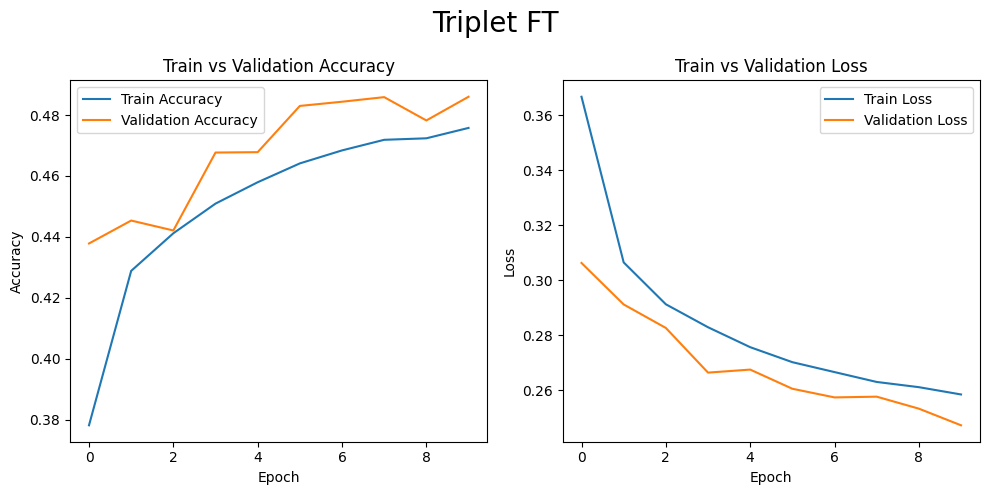

In [15]:
plot_checkpoints("Triplet FT", triplet_ft_history)

## ROC AUC Scores

### Utils Functions

In [24]:
def emb_dist(model: nn.Module, img1: torch.Tensor, img2: torch.Tensor) -> float:
  """
  Computes the cosine similarity between the embeddings of two images.

  Args:
    model (torch.nn.Module): The model used to generate embeddings.
    img1 (torch.Tensor): The first image tensor.
    img2 (torch.Tensor): The second image tensor.

  Returns:
    float: The cosine similarity between the two image embeddings.
  """
  emb1 = model(img1)
  emb2 = model(img2)

  dist = F.cosine_similarity(emb1, emb2)

  return dist.item()

In [25]:
_thresholds = np.arange(0.0, 1.0, 0.01)

def best_acc(y_vals: np.ndarray, scores: np.ndarray) -> Tuple[float, float]:
  """
  Finds the best accuracy and corresponding threshold for classification based on scores.

  Args:
    y_vals (np.ndarray): Array of true labels.
    scores (np.ndarray): Array of predicted scores.

  Returns:
    tuple: A tuple containing the best accuracy (float) and the best threshold (float).
  """
  best_acc = 0.0
  best_threshold = 0.0
  for threshold in _thresholds:
    y_hats = scores > threshold

    acc = np.mean(y_vals == y_hats)

    if acc > best_acc:
      best_acc = acc
      best_threshold = threshold

  return best_acc, best_threshold

In [26]:
def roc_scores(model: nn.Module, val_dl: DataLoader, get_y_vals: bool = True) -> Tuple[List[float], Optional[List[int]]]:
  """
  Computes ROC scores for the validation dataset using a given model.

  Args:
    model (torch.nn.Module): The model used to generate embeddings and compute scores.
    val_dl (torch.utils.data.DataLoader): DataLoader for the validation set.
    get_y_vals (bool, optional): Whether to return the true labels. Default is True.

  Returns:
    tuple: A tuple containing:
           - scores (List[float]): List of similarity scores.
           - y_vals (Optional[List[int]]): List of true labels if get_y_vals is True, otherwise None.
  """
  scores = []
  if get_y_vals:
    y_vals = []

  for i, (img1, img2, y_val) in enumerate(tqdm(val_dl)):
    if len(img1) == 0 or len(img2) == 0:
      continue

    img1 = img1.to(device)
    img2 = img2.to(device)

    y_val = y_val.item()
    if get_y_vals:
      y_vals.append(y_val)

    score = emb_dist(model, img1, img2)
    scores.append(score)

  if get_y_vals:
    return scores, y_vals
  return scores, None

### Prepare/Load Best Model

In [43]:
net_classifier_fe.load_state_dict(torch.load(f"{CHECKPOINTS_FOLDER}/classifier_fe.pth"))
net_classifier_fe.classify = False
net_classifier_fe.eval()
net_classifier_ft.load_state_dict(torch.load(f"{CHECKPOINTS_FOLDER}/classifier_ft.pth"))
net_classifier_ft.classify = False
net_classifier_ft.eval()
net_triplet_fe.load_state_dict(torch.load(f"{CHECKPOINTS_FOLDER}/triplet_fe.pth"))
net_triplet_fe.eval()
net_triplet_ft.load_state_dict(torch.load(f"{CHECKPOINTS_FOLDER}/triplet_ft.pth"))
net_triplet_ft.eval()

print("Best Models Loaded")

Best Models Loaded


### Calculating Scores

In [44]:
scores_classifier_fe, y_vals_classifier_fe = roc_scores(net_classifier_fe, veri_val_dl)
scores_classifier_ft, y_vals_classifier_ft = roc_scores(net_classifier_ft, veri_val_dl)
scores_triplet_fe, y_vals_triplet_fe = roc_scores(net_triplet_fe, veri_val_dl)
scores_triplet_ft, y_vals_triplet_ft = roc_scores(net_triplet_ft, veri_val_dl)

100%|██████████| 8805/8805 [02:10<00:00, 67.22it/s]


In [45]:
fpr_classifier_fe, tpr_classifier_fe, thresholds_classifier_fe = roc_curve(y_vals_classifier_fe, scores_classifier_fe)
auc_classifier_fe = roc_auc_score(y_vals_classifier_fe, scores_classifier_fe)
acc_classifier_fe, threshold_classifier_fe = best_acc(y_vals_classifier_fe, scores_classifier_fe)

fpr_classifier_ft, tpr_classifier_ft, thresholds_classifier_ft = roc_curve(y_vals_classifier_ft, scores_classifier_ft)
auc_classifier_ft = roc_auc_score(y_vals_classifier_ft, scores_classifier_ft)
acc_classifier_ft, threshold_classifier_ft = best_acc(y_vals_classifier_ft, scores_classifier_ft)

fpr_triplet_fe, tpr_triplet_fe, thresholds_triplet_fe = roc_curve(y_vals_triplet_fe, scores_triplet_fe)
auc_triplet_fe = roc_auc_score(y_vals_triplet_fe, scores_triplet_fe)
acc_triplet_fe, threshold_triplet_fe = best_acc(y_vals_triplet_fe, scores_triplet_fe)

fpr_triplet_ft, tpr_triplet_ft, thresholds_triplet_ft = roc_curve(y_vals_triplet_ft, scores_triplet_ft)
auc_triplet_ft = roc_auc_score(y_vals_triplet_ft, scores_triplet_ft)
acc_triplet_ft, threshold_triplet_ft = best_acc(y_vals_triplet_ft, scores_triplet_ft)

### Graph of Each Models

#### Classifier FE

Classifier FE AUC: 0.5718076665501981
Classifier FE ACC (threshold: 0.33): 55.23766100535734


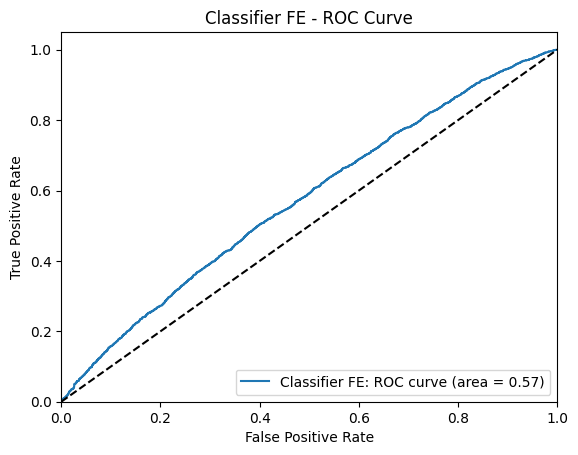

In [46]:
print(f"Classifier FE AUC: {auc_classifier_fe}")
print(f"Classifier FE ACC (threshold: {threshold_classifier_fe}): {acc_classifier_fe * 100}")

plt.plot(fpr_classifier_fe, tpr_classifier_fe, label='Classifier FE: ROC curve (area = %0.2f)' % auc_classifier_fe)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier FE - ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### Classifier FT

Classifier FT AUC: 0.8097403164620146
Classifier FT ACC (threshold: 0.17): 74.29613587142369


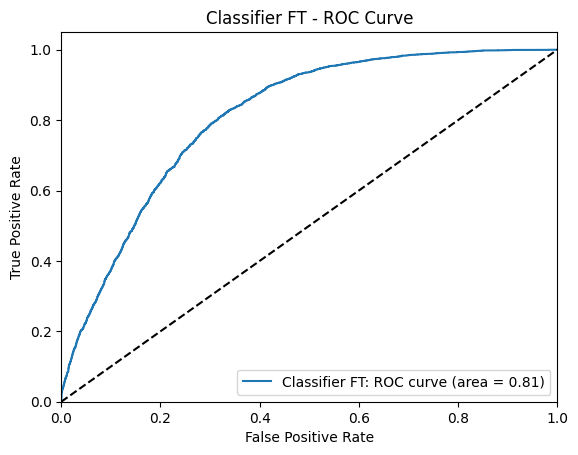

In [47]:
print(f"Classifier FT AUC: {auc_classifier_ft}")
print(f"Classifier FT ACC (threshold: {threshold_classifier_ft}): {acc_classifier_ft * 100}")

plt.plot(fpr_classifier_ft, tpr_classifier_ft, label='Classifier FT: ROC curve (area = %0.2f)' % auc_classifier_ft)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier FT - ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### Triplet FE

Triplet FE AUC: 0.6417430212388938
Triplet FE ACC (threshold: 0.16): 60.05927276872222


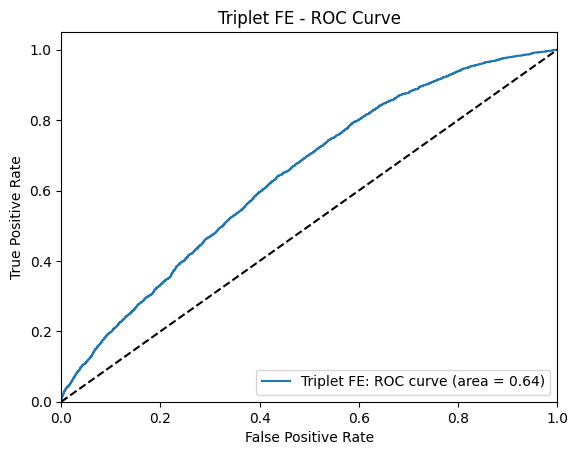

In [48]:
print(f"Triplet FE AUC: {auc_triplet_fe}")
print(f"Triplet FE ACC (threshold: {threshold_triplet_fe}): {acc_triplet_fe * 100}")

plt.plot(fpr_triplet_fe, tpr_triplet_fe, label='Triplet FE: ROC curve (area = %0.2f)' % auc_triplet_fe)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Triplet FE - ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### Triplet FT

Triplet FT AUC: 0.8022077832268477
Triplet FT ACC (threshold: 0.22): 74.72928302747064


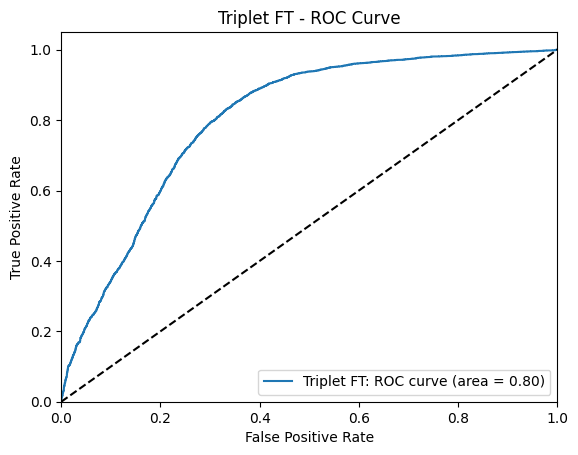

In [49]:
print(f"Triplet FT AUC: {auc_triplet_ft}")
print(f"Triplet FT ACC (threshold: {threshold_triplet_ft}): {acc_triplet_ft * 100}")

plt.plot(fpr_triplet_ft, tpr_triplet_ft, label='Triplet FT: ROC curve (area = %0.2f)' % auc_triplet_ft)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Triplet FT - ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### All Models

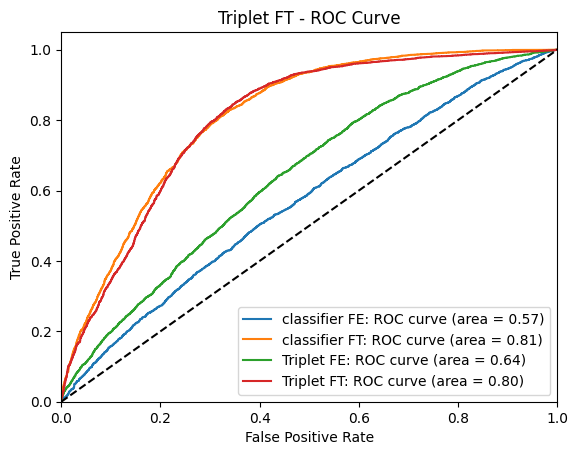

In [50]:
plt.plot(fpr_classifier_fe, tpr_classifier_fe, label='classifier FE: ROC curve (area = %0.2f)' % auc_classifier_fe)
plt.plot(fpr_classifier_ft, tpr_classifier_ft, label='classifier FT: ROC curve (area = %0.2f)' % auc_classifier_ft)
plt.plot(fpr_triplet_fe, tpr_triplet_fe, label='Triplet FE: ROC curve (area = %0.2f)' % auc_triplet_fe)
plt.plot(fpr_triplet_ft, tpr_triplet_ft, label='Triplet FT: ROC curve (area = %0.2f)' % auc_triplet_ft)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Triplet FT - ROC Curve')
plt.legend(loc="lower right")
plt.show()